In [19]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.optim import Adam
from torch.autograd import Variable



In [11]:
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(254),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [12]:
dataset = datasets.ImageFolder('training_set', transform=transform)
N_CLASSES = len(dataset.classes)

In [13]:
print(dataset.classes)
print(dataset[0])

['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']
(tensor([[[0.5412, 0.7255, 0.9647,  ..., 0.1608, 0.1529, 0.1490],
         [0.5804, 0.6745, 0.9529,  ..., 0.1569, 0.1490, 0.1529],
         [0.5098, 0.5765, 0.7608,  ..., 0.1333, 0.1490, 0.1804],
         ...,
         [0.0510, 0.0549, 0.0471,  ..., 0.0235, 0.0157, 0.0431],
         [0.0941, 0.1098, 0.0353,  ..., 0.0078, 0.0078, 0.0471],
         [0.0902, 0.1686, 0.1216,  ..., 0.0196, 0.0431, 0.2392]],

        [[0.6392, 0.7059, 0.9529,  ..., 0.2431, 0.2627, 0.2824],
         [0.7059, 0.7098, 0.9529,  ..., 0.2627, 0.2627, 0.2784],
         [0.6549, 0.6706, 0.7882,  ..., 0.2510, 0.2627, 0.2980],
         ...,
         [0.0510, 0.0549, 0.0510,  ..., 0.0392, 0.0275, 0.0510],
         [0.0980, 0.1098, 0.0353,  ..., 0.0314, 0.0275, 0.0431],
         [0.0941, 0.1686, 0.1216,  ..., 0.0353, 0.0588, 0.2196]],

        [[0.6314, 0.7333, 0.9647,  ..., 0.1255, 0.1059, 0.0980],
         [0.

In [14]:
train_set, val_set = random_split(dataset, [0.7, 0.3])
trainloader, valloader = DataLoader(train_set, batch_size=32, shuffle=True), DataLoader(val_set, batch_size=32)

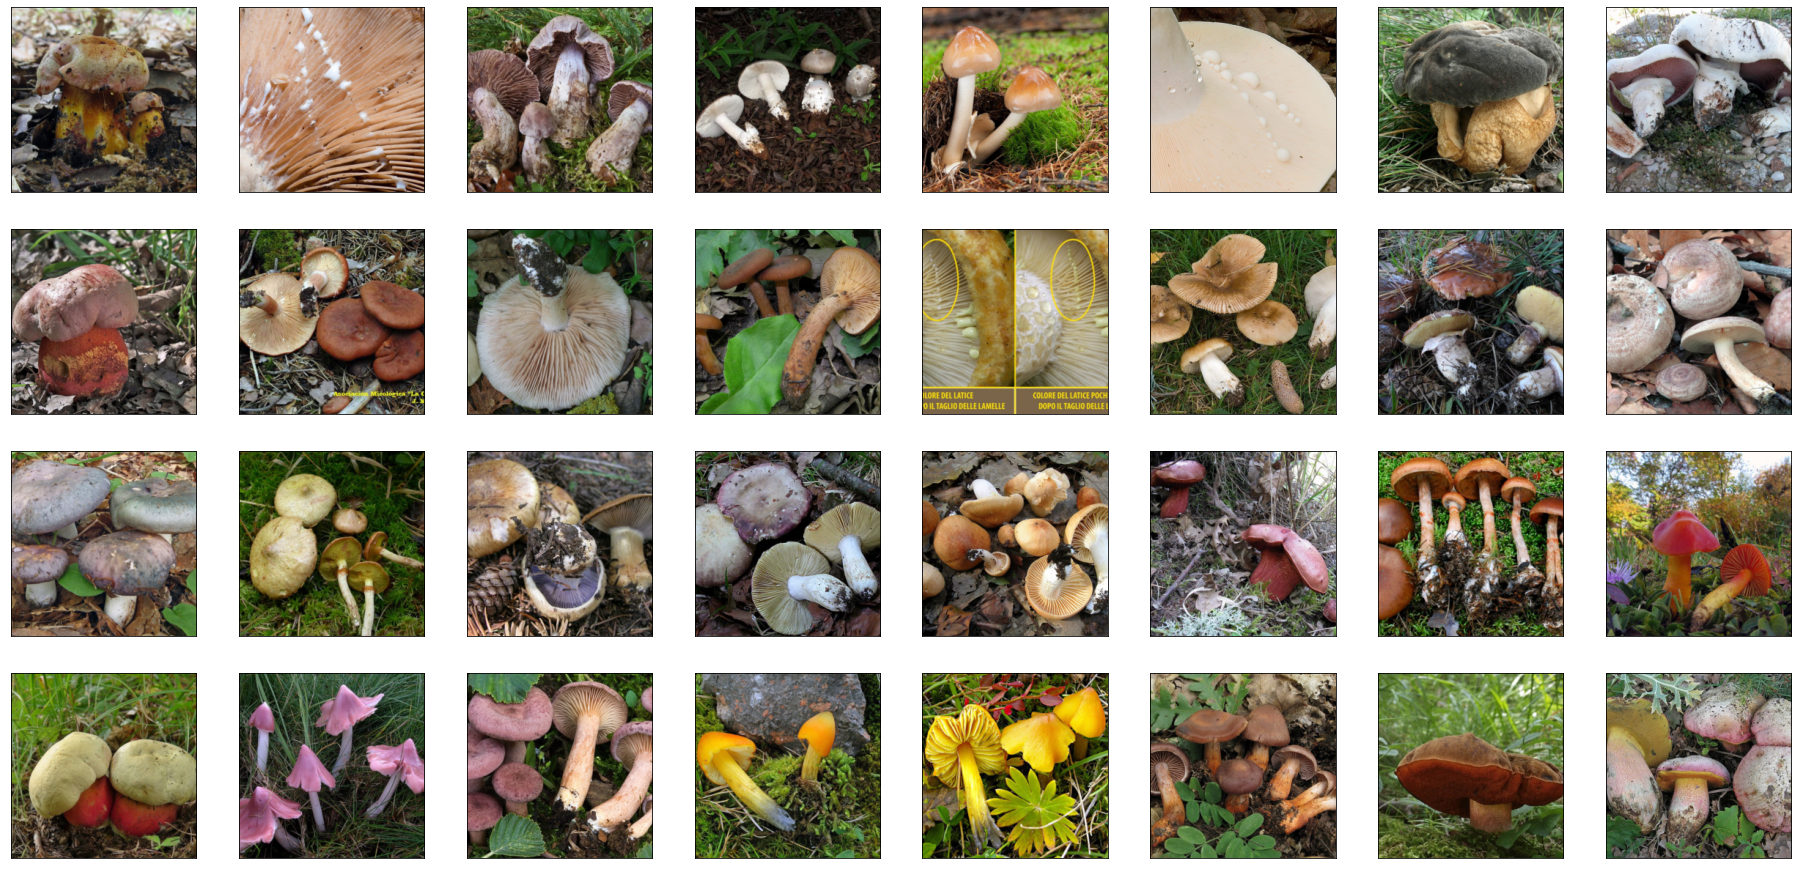

In [15]:
def imageshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
images, _ = next(iter(trainloader))
for i, image in enumerate(images[:32]):
    imageshow(image)

In [16]:
class mush_rec_nn(nn.Module):
    def __init__(self):
        super(mush_rec_nn, self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=10, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=10, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=10, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.cnn5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=10, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.fc1 = nn.Linear(256, N_CLASSES)
    
    def forward(self, input):
        output = F.relu(self.bn1(self.cnn1(input)))
        output = F.relu(self.bn2(self.cnn2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.cnn4(output)))     
        output = F.relu(self.bn5(self.cnn5(output)))     
        output = output.view(-1, 256)
        output = self.fc1(output)
        
        return output

model = mush_rec_nn()

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [18]:
def saveModel():
    path = "./mush_rec_model.pth"
    torch.save(model.state_dict(), path)

def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    accuracy = (100 * accuracy / total)
    return(accuracy)

def train(num_epochs):
    
    best_accuracy = 0.0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    
    model.to(device)

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(trainloader, 0):
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            optimizer.zero_grad()
            
            outputs = model(images)
            
            loss = loss_fn(outputs, labels)
            loss.backward()
            
            optimizer.step()

            running_loss += loss.item()
            if i % 1000 == 999:    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                running_loss = 0.0

        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy